In [2]:
import glob
import os
import tgt
import pandas as pd
from collections import defaultdict, Counter

In [4]:
fully_tagged_words = ['<<fp>>', '<<ui>>', '<<fs>>', '<<wip>>', '<<id>>', '<p:>']
part_tagged_words = ['<<fp', '<<ui', '<<fs', '<<pr']  # old var name: remove_marks
pause_word = '<p:>'
foreign_word = '<<fm>>'
remove_symbol = '’'  # implemented in clean_words. not yet tested

In [9]:
utt_in_dir = 'data/all_utts'
utt_out_dir = 'data/clean_utt_tg3'
write_tg_bool = True  # False
lang_dict = defaultdict(list)  # lang_dict[russ, urum, cs] = list(utt_name)
russ_words = set()
urum_words = set()
out_dict = defaultdict(list)  # to print out as pandas dataframe tsv
out_tsv_file = 'data/utt_spkr_lang_txt3.tsv'

if not os.path.isdir(utt_out_dir):
    os.mkdir(utt_out_dir)
for phone_file in sorted(glob.glob(f'{utt_in_dir}/*.TextGrid')):
    utt_id = os.path.basename(phone_file).split('.')[0]
#     print(utt_id)
#     phone_file = 'data/all_utts/0002_DoReCo_doreco_urum1249_UUM-TXT-AN-00000-A01.TextGrid'
    spkr_id = utt_id.split('-')[-1]
    keep_tiers = [f'ft@{spkr_id}', f'wd@{spkr_id}', f'ph@{spkr_id}']
    
    try:
        tgt_grid = tgt.io.read_textgrid(phone_file, encoding='utf-16')
    except:
        try:
            tgt_grid = tgt.io.read_textgrid(phone_file, encoding='utf-8')        
        except:
            print(f'** SKIP (encoding issues): {utt_id}')
            continue
    
    tgt_grid.delete_tiers(keep_tiers, complement=True)
    
    word_tier = tgt_grid.get_tier_by_name(f'wd@{spkr_id}')
    for fully_tagged_word in fully_tagged_words:
        tagged_words = word_tier.get_annotations_with_text(pattern=fully_tagged_word, n=0, regex=False)
        for tagged_obj in tagged_words:
            tagged_obj.text = f"{tagged_obj.text.replace('<', '').replace('>', '').replace(':', '')}_"
        
    if len(word_tier.annotations) == 0:
#         print(f'skipping: {phone_file}')
        continue
    elif len(word_tier.annotations) == 1 and word_tier.annotations[0].text == pause_word:
        continue
        
    elif len(word_tier.annotations) == 1 and word_tier.annotations[0].text == foreign_word:
#         print(f'RUSS <<fm>> only: {phone_file}')
        lang_dict['russ'].append(utt_id)
        out_dict['utt_id'].append(utt_id)
        out_dict['spkr_id'].append(spkr_id)
        out_dict['lang'].append('russ')
        out_dict['text'].append('@@@')
        out_dict['dur'].append(round(tgt_grid.get_tier_by_name(f'ft@{spkr_id}').end_time, 3))
        continue
    
    clean_words = []
    is_russ = False
    is_urum = False

#     print(' '.join([a.text for a in word_tier.annotations]))
    for annot in word_tier.annotations:
        if annot.text.endswith('_'):
            pass
        
        elif any(annot.text.startswith(part_tagged_word) for part_tagged_word in part_tagged_words):
#             print(annot)
            annot.text = f'{annot.text[2:4]}_{annot.text[5:-1]}'  # ex. fs_aba for <<fs>aba>
#             print(annot)
            is_urum = True
            urum_words.add(annot.text)

        elif annot.text.startswith('<<fm'):
            is_russ = True
            if len(annot.text) <= 6: # check not just <<fm>>
#                 print(' '.join([a.text for a in word_tier.annotations]))
                annot.text = '@'
            else:
                # replace with @
    #             print(annot)
                annot_word = annot.text[5:-1]
#                 annot.text = f'@{annot_word}'
                annot.text = f'_{annot_word}'
                russ_words.add(annot_word)
    #             print(annot)
        else:
            is_urum = True
            urum_words.add(annot.text)

        clean_words.append(annot.text)
        
    if all(clean_word.endswith('_') for clean_word in clean_words):
        continue  # all fully-tagged words
        
    lang = ''
    if is_russ and is_urum:
        lang = 'cs'
    elif is_russ:
        lang = 'russ'
    elif is_urum:
        lang = 'urum'
    else:
        print('NONE OF THE LANGS???')
        
    lang_dict[lang].append(utt_id)
            
    sent_tier = tgt_grid.get_tier_by_name(f'ft@{spkr_id}')
    sent_tier.name = f'sent@{spkr_id}'
    sentence = ' '.join([word.replace(remove_symbol, '') for word in clean_words])
    sent_tier.intervals[0].text = sentence
    out_dict['utt_id'].append(utt_id)
    out_dict['spkr_id'].append(spkr_id)
    out_dict['lang'].append(lang)
    out_dict['text'].append(sentence)
    out_dict['dur'].append(round(sent_tier.end_time, 3))
#     print(sentence)
        
    out_file = os.path.join(utt_out_dir, f'{utt_id}.TextGrid')
#     print(out_file)
    if write_tg_bool:
        tgt.io.write_to_file(tgt_grid, out_file)
#     break

df = pd.DataFrame(out_dict)
df.to_csv(out_tsv_file, sep='\t', index=False)

** SKIP (encoding issues): 0002_DoReCo_doreco_urum1249_UUM-TXT-AN-00000-A10


In [10]:
for lang, lang_list in lang_dict.items():
    print(lang)
    print(f'utt count: {len(lang_list)}')
    dur_list = df[df['lang'] == lang]['dur']
    print(f'total duration (sec): {round(sum(dur_list), 3)}')

urum
utt count: 752
total duration (sec): 3207.287
cs
utt count: 581
total duration (sec): 3772.205
russ
utt count: 40
total duration (sec): 78.949


In [11]:
print(len(russ_words))
print(len(urum_words))

618
3450


In [84]:
russ_word_file = 'data/russ_words.txt'
with open(russ_word_file, 'w') as w:
    for word in sorted(list(russ_words)):
        w.write(f'{word}\n')

In [85]:
urum_word_file = 'data/urum_words.txt'
with open(urum_word_file, 'w') as w:
    for word in sorted(list(urum_words)):
        w.write(f'{word}\n')

In [12]:
spkr_dict = {}
for spkr in sorted(set(df['spkr_id'])):
    spkr_dict[spkr] = Counter(df[df['spkr_id'] == spkr]['lang'])
spkr_dict

{'A01': Counter({'urum': 25, 'cs': 25, 'russ': 2}),
 'A02': Counter({'urum': 29, 'cs': 28, 'russ': 6}),
 'A03': Counter({'cs': 47, 'urum': 16, 'russ': 8}),
 'A04': Counter({'cs': 22, 'urum': 35}),
 'A05': Counter({'urum': 22, 'cs': 27, 'russ': 7}),
 'A06': Counter({'urum': 31, 'cs': 25, 'russ': 1}),
 'A07': Counter({'cs': 40, 'urum': 18, 'russ': 2}),
 'A08': Counter({'urum': 25, 'cs': 24, 'russ': 2}),
 'A09': Counter({'cs': 32, 'urum': 27, 'russ': 3}),
 'A10': Counter({'urum': 30, 'cs': 26}),
 'A11': Counter({'cs': 23, 'urum': 18, 'russ': 2}),
 'A12': Counter({'urum': 28, 'cs': 19}),
 'A13': Counter({'urum': 26, 'cs': 27}),
 'A14': Counter({'cs': 33, 'urum': 12}),
 'A15': Counter({'urum': 21, 'cs': 18, 'russ': 1}),
 'A16': Counter({'urum': 28, 'cs': 41}),
 'B01': Counter({'urum': 30, 'cs': 13}),
 'B02': Counter({'urum': 31, 'cs': 7}),
 'B03': Counter({'urum': 24, 'cs': 12}),
 'B04': Counter({'cs': 10, 'urum': 21}),
 'B06': Counter({'urum': 31, 'cs': 5}),
 'B07': Counter({'urum': 35, 'c

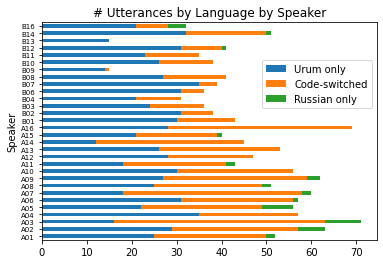

In [29]:
# visualize utt langs by speaker
cols = ['spkr', 'Urum only', 'Code-switched', 'Russian only']
sorted_spkrs = sorted(spkr_dict.keys())
urum_utts_by_spkr = [spkr_dict[spkr]['urum'] if 'urum' in spkr_dict[spkr] else 0 for spkr in sorted_spkrs]
russ_utts_by_spkr = [spkr_dict[spkr]['russ'] if 'russ' in spkr_dict[spkr] else 0 for spkr in sorted_spkrs]
mix_utts_by_spkr = [spkr_dict[spkr]['cs'] if 'cs' in spkr_dict[spkr] else 0 for spkr in sorted_spkrs]

utt_langs_by_spkr_df = pd.DataFrame({'spkr': sorted_spkrs, 
                                  'Urum only': urum_utts_by_spkr,
                                 'Code-switched': mix_utts_by_spkr, 
                                  'Russian only': russ_utts_by_spkr})

ax = utt_langs_by_spkr_df.plot( 
        x = 'spkr', 
        kind = 'barh', 
        stacked = True, 
        title = '# Utterances by Language by Speaker',
        xlabel = 'Speaker',
        mark_right = True) 
ax.legend(bbox_to_anchor=(1.0, 0.85))
ax.tick_params(axis='y', which='major', labelsize=7)
ax.get_figure().savefig('out/figs/utt_lang_spkr.pdf')

In [105]:
# how many urum words in my dict are NOT in eleanor's?
eleanor_urum_dict_file = 'eleanor/urum_dict_final.txt'
with open(eleanor_urum_dict_file, 'r') as f:
    eleanor_words = set([line.split('\t')[0] for line in f.readlines()])
eleanor_words

{'ökmätım',
 'amvelä',
 'ğalhirdıh',
 'ölerdılär',
 'äriši',
 'ikidä',
 'ordaikän',
 'ruski',
 'götürer',
 'musulmandırl',
 'airldılar',
 'siftäkının',
 'dädälärım',
 'yašındaidi',
 'birdır',
 'gürjistandan',
 'täräf',
 'bura',
 'išliya',
 'eddi',
 'günüsi',
 'savkhozdada',
 'urusetä',
 'babama',
 'išlirıh',
 'ävdän',
 'yoldur',
 'oturerıh',
 'traktori',
 'günümüzi',
 'yailalar',
 'gä',
 'gäräktädır',
 'jaalikän',
 'olmazda',
 'airlandılar',
 'bulurlar',
 'kartolmartol',
 'emahlari',
 'izın',
 'ona',
 'täräfä',
 'dutar',
 'darar',
 'sui',
 'isterıh',
 'semyamız',
 'dilda',
 'trudunan',
 'ambelä',
 'klasi',
 'bavlos',
 'gečmer',
 'vosemdesyat',
 'ohuttular',
 'čalıšerdıh',
 'čobannığa',
 'yohtur',
 'anonnari',
 'bišırirdi',
 'bülir',
 'komunistlärın',
 'edänäčen',
 'le',
 'yašamirdi',
 'istirdi',
 'ärımızä',
 'puh',
 'trapezondadan',
 'üči',
 'kimının',
 'olerdi',
 'toplanerlär',
 'getmirım',
 'dutmerdi',
 'išlär',
 'kövlärdändä',
 'kissäsıni',
 'čaimız',
 'čalıšerlar',
 'ärvänli',
 'gü

In [106]:
urum_words - eleanor_words

{'!',
 'a',
 'aha',
 'ai',
 'anamız',
 'aniki',
 'arg',
 'ataanam',
 'ağačın',
 'b',
 'ba',
 'bi',
 'bizım_halh',
 'bizın',
 'buidi',
 'böyü',
 'bülem',
 'davuzurna',
 'dilı',
 'dište',
 'dmanisis',
 'do',
 'druzni',
 'durii',
 'dvatsat',
 'e',
 'ed',
 'edditälä',
 'em',
 'erläšälär',
 'eše',
 'f',
 'g',
 'gi',
 'gidärım',
 'gru',
 'gyo',
 'gäl',
 'gü',
 'gürjis',
 'h',
 'hal',
 'i',
 'iz',
 'išlier',
 'k',
 'ka',
 'kask',
 'kh',
 'khara',
 'khristians>',
 'khristosdır',
 'kis',
 'käs',
 'kö',
 'kür',
 'la',
 'm',
 'm!',
 'mazanti',
 'me',
 'mı',
 'na',
 'nač',
 'ne',
 'ni',
 'noo',
 'nu_vot',
 'ohurlar',
 'okey',
 'ol',
 'onnardan',
 'ora',
 'ovahıt',
 'pakla',
 'paska',
 'per',
 'po',
 'pra',
 'ra',
 'russki',
 's',
 'savkho',
 'sayuzda',
 'selskhoz',
 'semyasiinän',
 'sva',
 't',
 'tezındän',
 'tiflis',
 'tsal',
 'tsalkaya_gäldılär',
 'turtsianın',
 'u',
 'uf',
 'ugu',
 'utr',
 'valik',
 'vete',
 'vot',
 'väd',
 'ya',
 'yašam',
 'yaše',
 'yašianda',
 'ä',
 'ävl',
 'ö',
 'öläng',
 'ü

In [4]:
# get phone seq from textgrids -> create urum dict
clean_tg_in_dir = 'data/clean_utt_tg2'
# phone_file = 'data/clean_utt_tg/0001_DoReCo_doreco_urum1249_UUM-TXT-AN-00000-A03.TextGrid'
dict_out_file = 'data/urum_only_dict_v3.txt'
word_dict = {}

for phone_file in sorted(glob.glob(f'{clean_tg_in_dir}/*.TextGrid')):
    tgt_gr = tgt.io.read_textgrid(phone_file, encoding='utf-8')
    utt_id = os.path.basename(phone_file).split('.')[0]
    spkr_id = utt_id.split('-')[-1]
    word_tier = tgt_gr.get_tier_by_name(f'wd@{spkr_id}')
    phone_tier = tgt_gr.get_tier_by_name(f'ph@{spkr_id}')

    word_times = []
    
    for word in word_tier:
        if not word.text.startswith('_'):  # '@' not in word.text
            word_times.append((word.text, word.start_time, word.end_time))

    for word_tup in word_times:
        # some phones look like <<fs>a>
        phones = phone_tier.get_annotations_between_timepoints(word_tup[1], word_tup[2], left_overlap=False, right_overlap=False)
#         word_dict[word_tup[0]] = ' '.join([phone.text.replace('J\\', 'J').replace('r\\_r', 'r') for phone in phones])
        word_dict[word_tup[0]] = ' '.join([phone.text.replace('r\\_r', 'r') for phone in phones])
    
# print(word_dict)
with open(dict_out_file, 'w') as w:
    for word in sorted(word_dict.keys()):
        w.write(f'{word}\t{word_dict[word]}\n')